In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [9]:
maxIter = 20  # 迭代次数
Re = 100  # 雷诺数
nx = 120  # 横向网格数量
ny = 80  # 纵向网格数量
ly = ny-1.0
q = 9  # Lattice dimensions and populations 格子维度
cx = nx/4  # 圆形障碍中心横坐标
cy = ny/2  # 圆形障碍中心纵坐标
r = ny/9  # Coordinates of the cylinder.
uLB = 0.04  # Velocity in lattice units.
nulb = uLB*r/Re
omega = 1.0 / (3.*nulb+0.5)  # 弛豫时间

In [10]:
###### Lattice Constants #######################################################
# Lattice velocities.
# D2Q9 模型
c = np.array([[0, 0], [1, 0], [0, -1],
           [-1, 0], [0, 1], [1, -1],
           [-1, -1], [-1, 1], [1, 1]])

In [11]:
# Lattice weights
t = np.array([0.44444444, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
  0.02777778, 0.02777778,0.02777778, 0.02777778])

In [12]:
noslip = [0, 3, 4, 1, 2, 7, 8, 5, 6]

In [13]:
i1 = [3, 6, 7]  # right wall.
i2 = [0, 2, 4]  # middle.
i3 = [1, 5, 8]  # left wall.

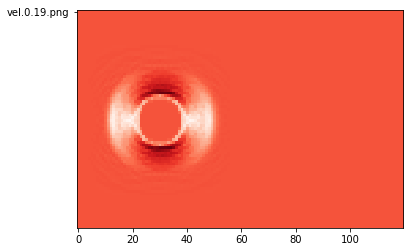

In [14]:
###### Function Definitions ####################################################
# 用于密度计算的辅助函数



def sumpop(fin): return np.sum(fin, axis=0)

# 平衡态分布函数
def equilibrium(rho, u): 
    cu = 3.0 * np.dot(c, u.transpose(1, 0, 2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = np.zeros((q, nx, ny))
    for i in range(q):
        feq[i, :, :] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq


###### Setup: 带有扰动的圆柱形障碍物和速度入口 ########
# 圆形障碍表达式
obstacle = np.fromfunction(lambda x, y: (x-cx)**2+(y-cy)**2 < r**2, (nx, ny))
vel = np.fromfunction(lambda d, x, y: (1-d)*uLB *
                   (1.0+1e-4*np.sin(y/ly*2*np.pi)), (2, nx, ny))
feq = equilibrium(1.0, vel)
fin = feq.copy()

###### Main loop ##########################################################

for time in range(maxIter):
    fin[i1, -1, :] = fin[i1, -2, :]  # 右边界流出处理
    rho = sumpop(fin)  # 计算宏观密度和速度
    u = np.dot(c.transpose(), fin.transpose((1, 0, 2)))/rho

    # 左边界处理：从已知速度求解密度
    u[:, 0, :] = vel[:, 0, :]
    rho[0, :] = 1./(1.-u[0, 0, :]) * \
        (sumpop(fin[i2, 0, :])+2.*sumpop(fin[i1, 0, :]))

    feq = equilibrium(rho, u)  # 左边界处理：Zou/He边界处理
    fin[i3, 0, :] = fin[i1, 0, :] + feq[i3, 0, :] - fin[i1, 0, :]
    fout = fin - omega * (fin - feq)  # 碰撞步骤
    for i in range(q):
        fout[i, obstacle] = fin[noslip[i], obstacle]
    for i in range(q):  # Streaming step.
        fin[i, :, :] = np.roll(
                np.roll(fout[i, :, :], c[i, 0], axis=0), c[i, 1], axis=1)





plt.clf()
plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
plt.plot("vel."+str(time/100).zfill(4)+".png")